# Fashion Image Search Engine

![](https://wwd.com/wp-content/uploads/2017/10/nyfwssd301-nocrop-w840-h1330-2x-1.jpg?w=910&h=511&crop=1)

***
In this project, I build a Fashion Image Search Engine (also called, Content Based Recommender Engine or CBR) using Tensorflow and Keras. In this project you will learn the following:

* Convolutional Neural Network
* Transfer Learning
* Architectures of ResNet 50, VGG 16 & Xception
* Image Similarity

I will be posting a blog post on this project as well on my website, you can check it out [here](https://keepingupwithdatascience.wordpress.com/).
***

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image # tải, xử lý ảnh
from PIL import Image # mở, xử lý và lưu các tệp hình ảnh
from random import sample # chọn một mẫu ngẫu nhiên từ một dãy hoặc tập hợp
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess #mô hình pretrained vgg và hàm tiền xử lý ảnh cho mô hình vgg
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess
from tensorflow.keras.models import Model # dùng để định nghĩa và làm việc với các model
from pathlib import Path # làm việc với đường dẫn tệp và thư mục
Image.LOAD_TRUNCATED_IMAGES = True #cho phép Image mở các tệp hình ảnh bị cắt xén/ k hoàn chỉnh
import requests # gửi các yêu cầu http để tải ảnh 
from io import BytesIO # dùng với requests 
import os #làm việc với thư mục
import time #làm việc với thời gian, dùng để đo thời gian


In [3]:
# Đọc data từ file
listing_data = pd.read_csv("../input/farfetch-listings/current_farfetch_listings.csv")

# Data Analysis

In [4]:
listing_data.head()

Unnamed: 0                                     availableSizes  brand.id  \
0           0                                                NaN      8360   
1           1  [{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...   2049368   
2           2                                                NaN     15514   
3           3               [{'scaleId': 0, 'size': 'One Size'}]     49486   
4           4                                                NaN     34624   

      brand.name gender  hasSimilarProducts        id  \
0        Miu Miu  women                True  13415450   
1  Self-Portrait  women                True  13784566   
2          Fendi  women                True  13377441   
3         A.P.C.  women               False  13744082   
4          Prada  women                True  13668256   

                                       images.cutOut  \
0  https://cdn-images.farfetch-contents.com/13/41...   
1  https://cdn-images.farfetch-contents.com/13/78...   
2  https://cdn-images.farfetch-contents.com/13/37...   
3  https://cdn-images.farfetch-contents.com/13/74...   
4  https://cdn-images.farfetch-contents.com/13/66...   

                                        images.model  isCustomizable  ...  \
0  https://cdn-images.farfetch-contents.com/13/41...           False  ...   
1  https://cdn-images.farfetch-contents.com/13/78...           False  ...   
2  https://cdn-images.farfetch-contents.com/13/37...           False  ...   
3  https://cdn-images.farfetch-contents.com/13/74...           False  ...   
4  https://cdn-images.farfetch-contents.com/13/66...           False  ...   

  priceInfo.currencyCode priceInfo.discountLabel  priceInfo.finalPrice  \
0                    SGD                     NaN                  1080   
1                    SGD                 20% Off                   392   
2                    SGD                     NaN                  1245   
3                    SGD                 20% Off                   308   
4                    SGD                     NaN                  1248   

  priceInfo.formattedFinalPrice priceInfo.formattedInitialPrice  \
0                        $1,080                          $1,080   
1                          $392                            $490   
2                        $1,245                          $1,245   
3                          $308                            $385   
4                        $1,248                          $1,248   

   priceInfo.initialPrice priceInfo.installmentsLabel priceInfo.isOnSale  \
0                    1080                         NaN              False   
1                     490                         NaN               True   
2                    1245                         NaN              False   
3                     385                         NaN               True   
4                    1248                         NaN              False   

                 shortDescription  stockTotal  
0       logo print strap sandals          130  
1          embroidered midi dress          14  
2  FendiMania sock style sneakers          68  
3                  top zip wallet           1  
4              slingback 65 pumps          78  

[5 rows x 23 columns]

In [5]:
# Kiểm tra shape (num_rows, num_colums)
listing_data.shape

(188817, 23)

In [6]:
# Bỏ cột: 0 column
listing_data.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# Kiểm tra dtypes
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188817 entries, 0 to 188816
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   availableSizes                   162711 non-null  object 
 1   brand.id                         188817 non-null  int64  
 2   brand.name                       188817 non-null  object 
 3   gender                           188817 non-null  object 
 4   hasSimilarProducts               188817 non-null  bool   
 5   id                               188817 non-null  int64  
 6   images.cutOut                    188817 non-null  object 
 7   images.model                     188817 non-null  object 
 8   isCustomizable                   188817 non-null  bool   
 9   merchandiseLabel                 56441 non-null   object 
 10  merchandiseLabelField            188817 non-null  object 
 11  merchantId                       188817 non-null  int64  
 12  pr

* Has priceInfo.installmentsLabel all null values.

In [8]:
# Bỏ cột priceInfo.installmentsLabel
listing_data.drop('priceInfo.installmentsLabel', axis=1, inplace=True)

In [9]:
# Kiểm tra % null của các cột
listing_data.isnull().sum() * 100 / listing_data.shape[0] 

availableSizes                     13.826086
brand.id                            0.000000
brand.name                          0.000000
gender                              0.000000
hasSimilarProducts                  0.000000
id                                  0.000000
images.cutOut                       0.000000
images.model                        0.000000
isCustomizable                      0.000000
merchandiseLabel                   70.108094
merchandiseLabelField               0.000000
merchantId                          0.000000
priceInfo.currencyCode              0.000000
priceInfo.discountLabel            63.834295
priceInfo.finalPrice                0.000000
priceInfo.formattedFinalPrice       0.000000
priceInfo.formattedInitialPrice     0.000000
priceInfo.initialPrice              0.000000
priceInfo.isOnSale                  0.000000
shortDescription                    0.000000
stockTotal                          0.000000
dtype: float64

In [10]:
# Lấy ra các dòng dữ liệu có cột merchandiseLabel không null
listing_data[~listing_data['merchandiseLabel'].isnull()].head()

availableSizes  brand.id  \
9   [{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...   1504165   
11  [{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...      2747   
13  [{'scaleId': 0, 'size': 'L'}, {'scaleId': 0, '...    168996   
15                                                NaN    769627   
18  [{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...      2765   

                       brand.name gender  hasSimilarProducts        id  \
9                      Rejina Pyo  women                True  13777585   
11                          Chloé  women                True  13704528   
13  Pleats Please By Issey Miyake  women                True  14107224   
15                       Burberry  women                True  13970008   
18              Alexander McQueen  women                True  13951735   

                                        images.cutOut  \
9   https://cdn-images.farfetch-contents.com/13/77...   
11  https://cdn-images.farfetch-contents.com/13/70...   
13  https://cdn-images.farfetch-contents.com/14/10...   
15  https://cdn-images.farfetch-contents.com/13/97...   
18  https://cdn-images.farfetch-contents.com/13/95...   

                                         images.model  isCustomizable  \
9   https://cdn-images.farfetch-contents.com/13/77...           False   
11  https://cdn-images.farfetch-contents.com/13/70...           False   
13  https://cdn-images.farfetch-contents.com/14/10...           False   
15  https://cdn-images.farfetch-contents.com/13/97...           False   
18  https://cdn-images.farfetch-contents.com/13/95...           False   

   merchandiseLabel  ... merchantId  priceInfo.currencyCode  \
9        New Season  ...       9359                     SGD   
11       New Season  ...       9359                     SGD   
13       New Season  ...       9359                     SGD   
15       New Season  ...       9359                     SGD   
18       New Season  ...       9359                     SGD   

   priceInfo.discountLabel priceInfo.finalPrice  \
9                      NaN                  989   
11                     NaN                 1790   
13                     NaN                  657   
15                     NaN                 1000   
18                     NaN                 3330   

    priceInfo.formattedFinalPrice priceInfo.formattedInitialPrice  \
9                            $989                            $989   
11                         $1,790                          $1,790   
13                           $657                            $657   
15                         $1,000                          $1,000   
18                         $3,330                          $3,330   

   priceInfo.initialPrice  priceInfo.isOnSale  \
9                     989               False   
11                   1790               False   
13                    657               False   
15                   1000               False   
18                   3330               False   

                   shortDescription stockTotal  
9      Blake herringbone midi dress         16  
11   pussy-bow rose-jacquard blouse         14  
13               pleated midi dress         13  
15   Margrette 50mm cow print pumps         10  
18  tie-neck houndstooth midi-dress          2  

[5 rows x 21 columns]

In [11]:
# Kiểm tra các nhóm trong merchandiseLabel
listing_data['merchandiseLabel'].value_counts()

New Season              41469
Positively Conscious    12324
Permanent Collection     1275
Seasonal Pick             741
Exclusive                 632
Name: merchandiseLabel, dtype: int64

In [12]:
# Bỏ cột merchandiseLabel
listing_data.drop('merchandiseLabel', axis=1, inplace=True)

In [13]:
# Phân tích cột priceInfo.discountLabel
# Lấy ra các dòng có priceInfo.discountLabel null
listing_data[listing_data['priceInfo.discountLabel'].isnull()].head()

availableSizes  brand.id brand.name gender  \
0                                   NaN      8360    Miu Miu  women   
2                                   NaN     15514      Fendi  women   
4                                   NaN     34624      Prada  women   
6  [{'scaleId': 0, 'size': 'One Size'}]     25354      Gucci  women   
7  [{'scaleId': 0, 'size': 'One Size'}]   1025204        MCM  women   

   hasSimilarProducts        id  \
0                True  13415450   
2                True  13377441   
4                True  13668256   
6                True  12562558   
7                True  13768073   

                                       images.cutOut  \
0  https://cdn-images.farfetch-contents.com/13/41...   
2  https://cdn-images.farfetch-contents.com/13/37...   
4  https://cdn-images.farfetch-contents.com/13/66...   
6  https://cdn-images.farfetch-contents.com/12/56...   
7  https://cdn-images.farfetch-contents.com/13/76...   

                                        images.model  isCustomizable  \
0  https://cdn-images.farfetch-contents.com/13/41...           False   
2  https://cdn-images.farfetch-contents.com/13/37...           False   
4  https://cdn-images.farfetch-contents.com/13/66...           False   
6  https://cdn-images.farfetch-contents.com/12/56...           False   
7  https://cdn-images.farfetch-contents.com/13/76...           False   

  merchandiseLabelField  merchantId priceInfo.currencyCode  \
0                 NoTag        9359                    SGD   
2                 NoTag        9140                    SGD   
4                 NoTag        9339                    SGD   
6                 NoTag       10952                    SGD   
7                 NoTag        9913                    SGD   

  priceInfo.discountLabel  priceInfo.finalPrice priceInfo.formattedFinalPrice  \
0                     NaN                  1080                        $1,080   
2                     NaN                  1245                        $1,245   
4                     NaN                  1248                        $1,248   
6                     NaN                  3740                        $3,740   
7                     NaN                  1323                        $1,323   

  priceInfo.formattedInitialPrice  priceInfo.initialPrice  priceInfo.isOnSale  \
0                          $1,080                    1080               False   
2                          $1,245                    1245               False   
4                          $1,248                    1248               False   
6                          $3,740                    3740               False   
7                          $1,323                    1323               False   

                              shortDescription  stockTotal  
0                    logo print strap sandals          130  
2               FendiMania sock style sneakers          68  
4                           slingback 65 pumps          78  
6  Green Dionysus GG small velvet shoulder bag          61  
7                           logo print satchel           5

* The null values in priceInfo.discountLabel indicate that there is no discount.

In [14]:
# Điền giá trị 0 cho các hàng null trong cột priceInfo.discountLabel
listing_data['priceInfo.discountLabel'] = listing_data['priceInfo.discountLabel'].fillna(0)

In [15]:
# Bỏ cột availableSizes
listing_data.drop('availableSizes', axis=1, inplace=True)

In [16]:
# Kiểm tra giá trị null
listing_data.isnull().sum()

brand.id                           0
brand.name                         0
gender                             0
hasSimilarProducts                 0
id                                 0
images.cutOut                      0
images.model                       0
isCustomizable                     0
merchandiseLabelField              0
merchantId                         0
priceInfo.currencyCode             0
priceInfo.discountLabel            0
priceInfo.finalPrice               0
priceInfo.formattedFinalPrice      0
priceInfo.formattedInitialPrice    0
priceInfo.initialPrice             0
priceInfo.isOnSale                 0
shortDescription                   0
stockTotal                         0
dtype: int64

In [17]:
def define_labels(df):
    # Gán nhãn cho loại sản phẩm dựa trên mô tả ngắn description
    def assign_product_category(description):
        description = description.lower()
        if 'shirt' in description or 't-shirt' in description or 'blouse' in description or 'top' in description:
            return 'Top'
        elif 'pants' in description or 'trousers' in description or 'jeans' in description or 'shorts' in description:
            return 'Bottom'
        elif 'dress' in description or 'gown' in description or 'skirt' in description:
            return 'Dress/Skirt'
        elif 'jacket' in description or 'coat' in description or 'blazer' in description:
            return 'Outerwear'
        elif 'shoes' in description or 'sneakers' in description or 'boots' in description or 'sandals' in description or 'pumps' in description or 'slides' in description:
            if 'sandals' in description:
                return 'Sandals'
            elif 'pumps' in description:
                return 'Pumps'
            elif 'slides' in description:
                return 'Slides'
            else:
                return 'Shoes'
        elif 'clutch' in description or 'tote' in description or 'bag' in description or 'backpack' in description or 'handbag' in description:
            if 'clutch' in description:
                return 'Clutch'
            elif 'tote' in description:
                return 'Tote'
            else:
                return 'Bag'
        elif 'hat' in description or 'cap' in description or 'scarf' in description or 'accessory' in description or 'belt' in description or 'hair clips' in description:
            return 'Accessory'
        elif 'suit' in description or 'tuxedo' in description:
            return 'Suit'
        elif 'sweater' in description or 'hoodie' in description or 'knitwear' in description:
            return 'Knitwear'
        elif 'swim' in description or 'bikini' in description or 'swimsuit' in description:
            return 'Swimwear'
        elif 'underwear' in description or 'lingerie' in description or 'bra' in description or 'briefs' in description:
            return 'Underwear'
        elif 'activewear' in description or 'sportswear' in description or 'gym' in description or 'yoga' in description or 'workout' in description or 'training' in description:
            return 'Athletic Wear'
        elif 'wallet' in description or 'cardholder' in description:
            return 'Wallet'
        elif 'ring' in description or 'jewelry' in description or 'necklace' in description or 'bracelet' in description:
            return 'Jewelry'
        elif 'vase' in description or 'plate' in description or 'tray' in description or 'goblet' in description:
            return 'Home Decor'
        elif 'tea pot' in description or 'bookends' in description:
            return 'Home Decor'
        else:
            return 'Other'

    # Gán nhãn cho loại sản phẩm
    df['product_category'] = df['shortDescription'].apply(assign_product_category)

    return df
define_labels(listing_data)

brand.id     brand.name  gender  hasSimilarProducts        id  \
0           8360        Miu Miu   women                True  13415450   
1        2049368  Self-Portrait   women                True  13784566   
2          15514          Fendi   women                True  13377441   
3          49486         A.P.C.   women               False  13744082   
4          34624          Prada   women                True  13668256   
...          ...            ...     ...                 ...       ...   
188812     59394     Fornasetti  unisex               False  10047577   
188813     59394     Fornasetti  unisex               False  10047571   
188814     59394     Fornasetti  unisex               False  10047569   
188815     59394     Fornasetti  unisex               False  10047567   
188816     59394     Fornasetti  unisex               False  10047563   

                                            images.cutOut  \
0       https://cdn-images.farfetch-contents.com/13/41...   
1       https://cdn-images.farfetch-contents.com/13/78...   
2       https://cdn-images.farfetch-contents.com/13/37...   
3       https://cdn-images.farfetch-contents.com/13/74...   
4       https://cdn-images.farfetch-contents.com/13/66...   
...                                                   ...   
188812  https://cdn-images.farfetch-contents.com/10/04...   
188813  https://cdn-images.farfetch-contents.com/10/04...   
188814  https://cdn-images.farfetch-contents.com/10/04...   
188815  https://cdn-images.farfetch-contents.com/10/04...   
188816  https://cdn-images.farfetch-contents.com/10/04...   

                                             images.model  isCustomizable  \
0       https://cdn-images.farfetch-contents.com/13/41...           False   
1       https://cdn-images.farfetch-contents.com/13/78...           False   
2       https://cdn-images.farfetch-contents.com/13/37...           False   
3       https://cdn-images.farfetch-contents.com/13/74...           False   
4       https://cdn-images.farfetch-contents.com/13/66...           False   
...                                                   ...             ...   
188812  https://cdn-images.farfetch-contents.com/10/04...           False   
188813  https://cdn-images.farfetch-contents.com/10/04...           False   
188814  https://cdn-images.farfetch-contents.com/10/04...           False   
188815  https://cdn-images.farfetch-contents.com/10/04...           False   
188816  https://cdn-images.farfetch-contents.com/10/04...           False   

       merchandiseLabelField  merchantId priceInfo.currencyCode  \
0                      NoTag        9359                    SGD   
1                      NoTag        9319                    SGD   
2                      NoTag        9140                    SGD   
3                      NoTag        9031                    SGD   
4                      NoTag        9339                    SGD   
...                      ...         ...                    ...   
188812                 NoTag        9089                    SGD   
188813                 NoTag        9089                    SGD   
188814                 NoTag        9089                    SGD   
188815                 NoTag        9089                    SGD   
188816                 NoTag        9089                    SGD   

       priceInfo.discountLabel  priceInfo.finalPrice  \
0                            0                  1080   
1                      20% Off                   392   
2                            0                  1245   
3                      20% Off                   308   
4                            0                  1248   
...                        ...                   ...   
188812                       0                   207   
188813                       0                   207   
188814                       0                   207   
188815                       0                   207   
188816                       0                   207

In [18]:
#Kiểm tra các nhóm trong product_category
category_counts = listing_data['product_category'].value_counts()
print(category_counts)

Other            31695
Top              30117
Dress/Skirt      25795
Bottom           16752
Bag              13748
Outerwear        13194
Jewelry          10158
Shoes             9414
Sandals           6255
Accessory         6056
Tote              4900
Pumps             3888
Knitwear          3875
Underwear         3025
Wallet            2967
Suit              2611
Clutch            1805
Swimwear          1503
Slides             571
Home Decor         462
Athletic Wear       26
Name: product_category, dtype: int64


In [19]:
def load_images():
    
    # Lưu trữ đường dẫn thư mục vào một biến
    cutout_img_dir = "../input/farfetch-listings/cutout-img/cutout"
    model_img_dir = "../input/farfetch-listings/model-img/model"
    
    # Liệt kê các hình ảnh trong các thư mục này và lưu vào các biến
    cutout_images = os.listdir(cutout_img_dir)
    model_images = os.listdir(model_img_dir)
    
    # Tải ngẫu nhiên 10 hình ảnh Cutout: Lấy ngẫu nhiên 10 hình ảnh từ danh sách trên
    sample_cutout_images = sample(cutout_images, 10)
    fig = plt.figure(figsize=(10, 5))
    
    print("==============Hình ảnh Cutout==============")
    for i, img_name in enumerate(sample_cutout_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(cutout_img_dir, img_name)  # Đường dẫn đầy đủ đến hình ảnh
        loaded_img = image.load_img(img_path)  # Tải hình ảnh
        img_array = image.img_to_array(loaded_img, dtype='int')  # Chuyển hình ảnh thành mảng
        plt.imshow(img_array)  # Hiển thị hình ảnh
        plt.axis('off')  # Tắt trục để hiển thị hình ảnh rõ ràng hơn
        
    plt.show()  # Hiển thị tất cả hình ảnh
    print()
    
    # Tải ngẫu nhiên 10 hình ảnh Model: Lấy ngẫu nhiên 10 hình ảnh từ danh sách trên
    sample_model_images = sample(model_images, 10)
    fig = plt.figure(figsize=(10, 5))
    
    print("==============Hình ảnh Model==============")
    for i, img_name in enumerate(sample_model_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(model_img_dir, img_name)  # Đường dẫn đầy đủ đến hình ảnh
        loaded_img = image.load_img(img_path)  # Tải hình ảnh
        img_array = image.img_to_array(loaded_img, dtype='int')  # Chuyển hình ảnh thành mảng
        plt.imshow(img_array)  # Hiển thị hình ảnh
        plt.axis('off')  # Tắt trục để hiển thị hình ảnh rõ ràng hơn
        
    plt.show()  # Hiển thị tất cả hình ảnh

==============Hình ảnh Cutout==============


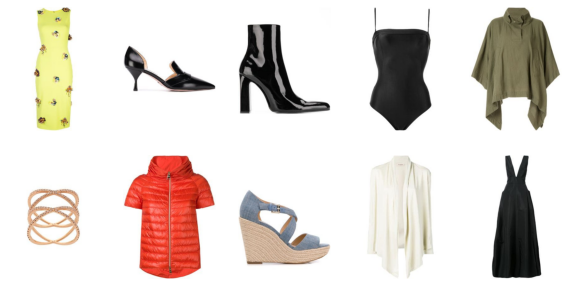


==============Hình ảnh Model==============


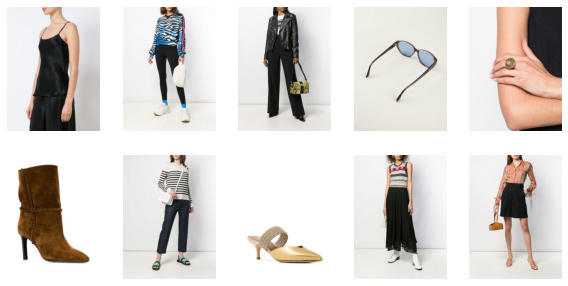

In [20]:
load_images()

In [21]:
# Lưu trữ đường dẫn thư mục vào một biến
cutout_img_dir = "../input/farfetch-listings/cutout-img/cutout"
model_img_dir = "../input/farfetch-listings/model-img/model"

# Liệt kê các file trong thư mục và lưu vào biến
cutout_images = os.listdir(cutout_img_dir)
model_images = os.listdir(model_img_dir)

In [22]:
# hàm trích xuất tên ảnh dựa vào đường dẫn hình ảnh
def extractImageName(x):
    # Đảo ngược chuỗi đường dẫn hình ảnh
    x_inv = x[::-1]

    # Tìm vị trí của dấu '/'
    slash_idx = x_inv.find('/')

    # Trích xuất phần của chuỗi từ vị trí dấu '/' đến cuối là tên hình ảnh
    return x[-slash_idx:]

# Áp dụng hàm extractImageName cho cột 'images.cutOut' để trích xuất tên hình ảnh cutout và lưu vào cột mới 'cutOutimageNames'
listing_data['cutOutimageNames'] = listing_data['images.cutOut'].apply(lambda x: extractImageName(x))

# Áp dụng hàm extractImageName cho cột 'images.model' để trích xuất tên hình ảnh model và lưu vào cột mới 'modelimageNames'
listing_data['modelimageNames'] = listing_data['images.model'].apply(lambda x: extractImageName(x))


In [23]:
# Chỉ lấy những dòng dữ liệu mà ta có ảnh trong 2 thư mục ảnh
listing_data = listing_data[listing_data['cutOutimageNames'].isin(cutout_images)]
listing_data = listing_data[listing_data['modelimageNames'].isin(model_images)]

In [24]:
# Bỏ chỉ số cũ, đặt lại chỉ số của df
listing_data.reset_index(drop=True, inplace=True)

In [25]:
# Sửa lại đường dẫn tới hình ảnh trong 2 thư mục bằng cách kết hợp với tên ảnh vừa trích xuất ở trên
listing_data['cutOutImages_path'] = cutout_img_dir + '/' + listing_data['cutOutimageNames']
listing_data['modelImages_path'] = model_img_dir + '/' + listing_data['modelimageNames']

In [26]:
# Bỏ cột cutOutimageNames, cutOutimageNames
listing_data.drop(['cutOutimageNames', 'cutOutimageNames'], axis=1, inplace=True)

Hình ảnh thể hiện một belted shorts
Giá: $178
Thương hiệu: Alice+Olivia



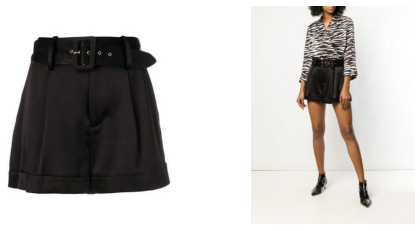

In [27]:
# Chọn ngẫu nhiên một hàng từ dataframe để hiển thị thông tin sản phẩm
random_idx = np.random.randint(low=0, high=listing_data.shape[0] - 1)

# Lấy đường dẫn của hình ảnh cutout và model, giá, mô tả và thương hiệu tương ứng
cutOut_img_path = listing_data.iloc[random_idx]['cutOutImages_path']
model_img_path = listing_data.iloc[random_idx]['modelImages_path']
price = listing_data.iloc[random_idx]['priceInfo.formattedFinalPrice']
desc = listing_data.iloc[random_idx]['shortDescription']
brand = listing_data.iloc[random_idx]['brand.name']

# Load hình ảnh từ đường dẫn
cutOut_img = image.load_img(cutOut_img_path)
cutOut_img_arr = image.img_to_array(cutOut_img, dtype='int')
model_img = image.load_img(model_img_path)
model_img_arr = image.img_to_array(model_img, dtype='int')

# Hiển thị hình ảnh, giá, mô tả và thương hiệu
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
print("Hình ảnh thể hiện một {}".format(desc))
print("Giá: {}".format(price))
print("Thương hiệu: {}".format(brand))
print()
ax[0].imshow(cutOut_img_arr)
ax[1].imshow(model_img_arr)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Image Search Engine using Keras and Tensorflow

In [28]:
'''
So sánh 3 mô hình khác nhau

1. VGG 16
2. ResNet 50
3. Xception
'''

class FeatureExtractor:
    
    # Constructor (hàm khởi tạo)
    def __init__(self, arch='VGG'):
        
        self.arch = arch
        
        # Sử dụng VGG-16 với trọng số từ ImageNet
        if self.arch == 'VGG':
            base_model = VGG16(weights='imagenet')
            self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
        
        # Sử dụng ResNet 50 với trọng số từ ImageNet
        elif self.arch == 'ResNet':
            base_model = ResNet50(weights='imagenet')
            self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
        
        # Sử dụng Xception với trọng số từ ImageNet
        elif self.arch == 'Xception':
            base_model = Xception(weights='imagenet')
            self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
            
    # Phương thức trích xuất đặc trưng hình ảnh
    def extract_features(self, img):
        
        # Mô hình VGG 16 & ResNet 50 yêu cầu kích thước ảnh đầu vào là 224x224, còn Xception là 299x299
        if self.arch == 'VGG' or self.arch == 'ResNet':
            img = img.resize((224, 224))
        elif self.arch == 'Xception':
            img = img.resize((299, 299))
        
        # Chuyển đổi kênh ảnh sang RGB
        img = img.convert('RGB')
        
        # Chuyển đổi ảnh thành mảng (array)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        # Tiền xử lý đầu vào theo mô hình tương ứng
        if self.arch == 'VGG':
            x = vgg_preprocess(x)
            
        elif self.arch == 'ResNet':
            x = resnet_preprocess(x)
            
        elif self.arch == 'Xception':
            x = xception_preprocess(x)
        
        # Trích xuất đặc trưng
        features = self.model.predict(x)
        
        # Chuẩn hóa (scale) các đặc trưng bằng cách chia cho L2-norm ( độ dài của vector feature)
        features = features / np.linalg.norm(features)
        
        return features

## Testing the Feature Extractor

* VGG 19
* ResNet 50
* Xception

In [29]:
# chọn ngẫu nhiên 10000 ảnh trong modelImages để trích xuất đặc trưng
index_values = np.random.randint(low=0, high=listing_data.shape[0], size=10000)
modelImages = listing_data.iloc[index_values]['modelImages_path']

In [31]:
resnet_feature_extractor = FeatureExtractor(arch='ResNet')  # Khởi tạo đối tượng trích xuất đặc trưng với mô hình ResNet
vgg_feature_extractor = FeatureExtractor(arch='VGG')  # Khởi tạo đối tượng trích xuất đặc trưng với mô hình VGG 16
xception_feature_extractor = FeatureExtractor(arch='Xception')  # Khởi tạo đối tượng trích xuất đặc trưng với mô hình Xception


91897856/91884032 [==============================] - 1s 0us/step


**1. ResNet 50**

***
* ResNet stands for Residual Network. 
* The ResNet 50 is a 50 layer deep network.
* It had a special unit or a special connection called the skip connections, which allowed to train these deep layered models effeciently.
* In the skip connection, the inputs are directly connected to the output layer. Then the network is forced to model h(x) - x, where h(x) hypothesis function and x is the input. This is called residual learning as we are modelling the residuals (errors).
* ResNet is also available in 34 layers as well as 152 layers deep networks.
***

In [ ]:
# Tạo đối tượng mô hình và trích xuất đặc trưng của 10000 hình ảnh hàng đầu (ResNet)
resnet_feature_extractor = FeatureExtractor(arch='ResNet')  # Khởi tạo đối tượng trích xuất đặc trưng với mô hình ResNet

start_time = time.time()  # Bắt đầu đo thời gian thực thi

# Tạo dictionary để lưu trữ các đặc trưng và chỉ số của hình ảnh
image_features_resnet = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = resnet_feature_extractor.extract_features(img)  # Trích xuất đặc trưng từ ảnh
    image_features_resnet[idx] = feature  # Lưu đặc trưng vào dictionary với khóa là chỉ số của ảnh

end_time = time.time()  # Kết thúc đo thời gian thực thi
elapsed_time = end_time - start_time  # Tính thời gian thực thi

print("Thời gian thực thi:", elapsed_time, "giây")  # In ra thời gian thực thi

**2. VGG 16**

***
* A relatively simple architecture.
* Consists of 2 or 3 convolutional layers followed by a pooling layer, then again 2 or 3 convolutional layers and a pooling layer.
* The VGG architecture reaches upto either 16 or 19 layered network depending on the variant. (In this case, I have used VGG 16, i.e the 16 layered variant.)
***

In [129]:
# Tạo đối tượng mô hình và trích xuất đặc trưng của 10000 hình ảnh hàng đầu (VGG 16)
vgg_feature_extractor = FeatureExtractor(arch='VGG')  # Khởi tạo đối tượng trích xuất đặc trưng với mô hình VGG 16

# Tạo dictionary để lưu trữ các đặc trưng và chỉ số của hình ảnh
image_features_vgg = {}
start_time = time.time()  # Đo thời gian bắt đầu

for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Trích xuất đặc trưng và lưu vào dictionary
    try:
        img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
        feature = vgg_feature_extractor.extract_features(img)  # Trích xuất đặc trưng từ ảnh
        image_features_vgg[idx] = feature  # Lưu đặc trưng vào dictionary với khóa là chỉ số của ảnh
    except:
        print(idx)  # In ra chỉ số của ảnh nếu xảy ra lỗi

end_time = time.time()  # Đo thời gian kết thúc

elapsed_time = end_time - start_time  # Tính thời gian thực thi
print("Thời gian thực thi:", elapsed_time, "giây")  # In ra thời gian thực thi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Thời gian thực thi: 1.1364004611968994 giây


**3. Xception**
***
* Xception stands for Extreme Inception (Inception is another CNN architecture).
* There is a special type of layer in this architecture called depthwise separable convolution layer.
* A normal convolution layer tries to simultaneously capture both spatial patterns (eg. Oval, Square, Circle) and cross-channel patterns (eg. Face, Nose, Ears etc).
* A depthwise separable convolution layers makes an assumption that both these patterns (spatial & cross-channel) can be modeled separately.
* Hence, the depthwise separable convolution layer consists of 2 parts. The first part looks for the spatial patterns while the second part looks for the cross channel patterns.
***

In [130]:
# Tạo đối tượng mô hình và trích xuất đặc trưng của 10000 hình ảnh hàng đầu (Xception)
xception_feature_extractor = FeatureExtractor(arch='Xception')  # Khởi tạo đối tượng trích xuất đặc trưng với mô hình Xception

# Tạo dictionary để lưu trữ các đặc trưng và chỉ số của hình ảnh
image_features_xception = {}
start_time = time.time()  # Đo thời gian bắt đầu

for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Trích xuất đặc trưng và lưu vào dictionary
    img = image.load_img(img_path)  # Đọc ảnh từ đường dẫn
    feature = xception_feature_extractor.extract_features(img)  # Trích xuất đặc trưng từ ảnh
    image_features_xception[idx] = feature  # Lưu đặc trưng vào dictionary với khóa là chỉ số của ảnh

end_time = time.time()  # Đo thời gian kết thúc

elapsed_time = end_time - start_time  # Tính thời gian thực thi
print("Thời gian thực thi:", elapsed_time, "giây")  # In ra thời gian thực thi

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Thời gian thực thi: 3.282703161239624 giây


In [131]:
import pickle

# Lưu trữ các đặc trưng của ResNet vào tệp .pkl
with open('image_features_resnet.pkl', 'wb') as f:
    pickle.dump(image_features_resnet, f)

# Lưu trữ các đặc trưng của VGG vào tệp .pkl
with open('image_features_vgg.pkl', 'wb') as f:
    pickle.dump(image_features_vgg, f)

# Lưu trữ các đặc trưng của Xception vào tệp .pkl
with open('image_features_xception.pkl', 'wb') as f:
    pickle.dump(image_features_xception, f)

In [33]:
import pickle

# Đọc và tải các đặc trưng hình ảnh (features) đã được trích xuất bằng mô hình ResNet từ file 'image_features_resnet.pkl'
with open('/kaggle/input/feature-extraction/image_features_resnet.pkl', 'rb') as f:
    image_features_resnet = pickle.load(f)

# Đọc và tải các đặc trưng hình ảnh (features) đã được trích xuất bằng mô hình VGG từ file 'image_features_vgg.pkl'
with open('/kaggle/input/feature-extraction/image_features_vgg.pkl', 'rb') as f:
    image_features_vgg = pickle.load(f)

# Đọc và tải các đặc trưng hình ảnh (features) đã được trích xuất bằng mô hình Xception từ file 'image_features_xception.pkl'
with open('/kaggle/input/feature-extraction/image_features_xception.pkl', 'rb') as f:
    image_features_xception = pickle.load(f)

# Testing the 3 architecture performance

In [34]:
with open('/kaggle/input/feature-extraction/image_features_resnet.pkl', 'rb') as f:
    image_features_resnet = pickle.load(f)
with open('/kaggle/input/feature-extraction/image_features_vgg.pkl', 'rb') as f:
    image_features_vgg = pickle.load(f)
with open('/kaggle/input/feature-extraction/image_features_xception.pkl', 'rb') as f:
    image_features_xception = pickle.load(f)

In [35]:
def testModel(img_url):
    
    # Kiểm tra các kiến trúc trên các hình ảnh bên ngoài
    
    '''Đọc đường dẫn url được chèn'''
    img_url = img_url
    response = requests.get(img_url)
    queryImage = Image.open(BytesIO(response.content))
    
    # Sử dụng mô hình VGG 16 để tạo ra các hình ảnh tương tự
    queryFeatures_Resnet = resnet_feature_extractor.extract_features(queryImage)

    # 2. VGG 16
    queryFeatures_Vgg = vgg_feature_extractor.extract_features(queryImage)

    # 3. Xception
    queryFeatures_Xception = xception_feature_extractor.extract_features(queryImage)
    
    # Tính độ tương tự giữa các đặc trưng của truy vấn và mỗi hình ảnh khác trong image_features_vgg, image_features_resnet, image_features_xception
    # 1. ResNet
    similarity_images_resnet = {}
    for idx, feat in image_features_resnet.items():

        # Tính độ tương tự bằng cách sử dụng khoảng cách Euclid
        similarity_images_resnet[idx] = np.sum((queryFeatures_Resnet - feat)**2) ** 0.5
    # Trích xuất top 10 hình ảnh tương tự
    similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
    top_10_simiarity_scores_resnet = [score for _, score in similarity_resnet_sorted][ : 10]
    top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]

    # 2. VGG 16
    similarity_images_vgg = {}
    for idx, feat in image_features_vgg.items():

        # Tính độ tương tự bằng cách sử dụng khoảng cách Euclid
        similarity_images_vgg[idx] = np.sum((queryFeatures_Vgg - feat)**2) ** 0.5
    # Trích xuất top 10 hình ảnh tương tự
    similarity_vgg_sorted = sorted(similarity_images_vgg.items(), key = lambda x : x[1], reverse=False)
    top_10_simiarity_scores_vgg = [score for _, score in similarity_vgg_sorted][ : 10]
    top_10_indexes_vgg = [idx for idx, _ in similarity_vgg_sorted][ : 10]

    # 3. Xception
    similarity_images_xception = {}
    for idx, feat in image_features_xception.items():
    
        # Tính độ tương tự bằng cách sử dụng khoảng cách Euclid
        similarity_images_xception[idx] = np.sum((queryFeatures_Xception - feat)**2) ** 0.5
    # Trích xuất top 10 hình ảnh tương tự
    similarity_xception_sorted = sorted(similarity_images_xception.items(), key = lambda x : x[1], reverse=False)
    top_10_simiarity_scores_xception = [score for _, score in similarity_xception_sorted][ : 10]
    top_10_indexes_xception = [idx for idx, _ in similarity_xception_sorted][ : 10]

    
    
    # Vẽ các hình ảnh
    # 1. ResNet
    top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
    brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']

    # 2. VGG 16
    top_10_similar_imgs_VGG = listing_data.iloc[top_10_indexes_vgg]['modelImages_path']
    brand_VGG = listing_data.iloc[top_10_indexes_vgg]['brand.name']


    # 3. Xception
    top_10_similar_imgs_Xception = listing_data.iloc[top_10_indexes_xception]['modelImages_path']
    brand_Xception = listing_data.iloc[top_10_indexes_xception]['brand.name']
    
    
    print("===================== HÌNH ẢNH TRUY VẤN ==========================")
    plt.figure(figsize=(8,8))
    queryImage = image.img_to_array(queryImage, dtype='int')
    plt.imshow(queryImage)
    plt.axis('off')
    plt.show()
    print("=============================================================")

    print("========================================== Kết quả ResNet =============================================")
    fig = plt.figure(figsize=(20,10))
    for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Resnet, brand_Resnet)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()
    print("======================================================================================================")
    print()
    print()

    print("========================================== Kết quả VGG 16 ============================================")
    fig = plt.figure(figsize=(20,10))
    for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_VGG, brand_VGG)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()
    print("======================================================================================================")
    print()
    print()

    print("========================================== Kết quả Xception ===========================================")
    fig = plt.figure(figsize=(20,10))
    for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Xception, brand_Xception)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off') 
    plt.show()
    print("==================================================================================================")

===================== HÌNH ẢNH TRUY VẤN ==========================


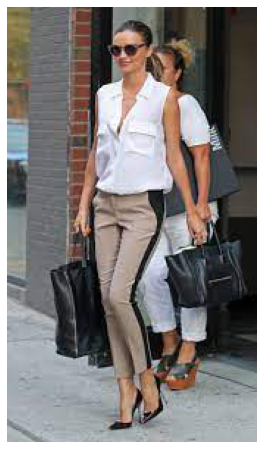

========================================== Kết quả ResNet =============================================


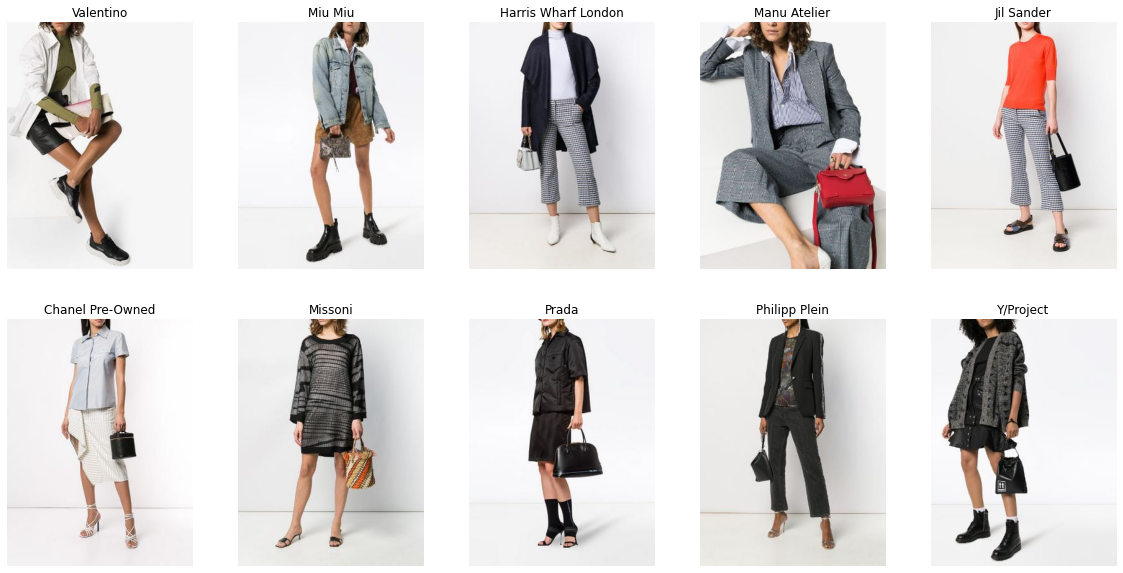



========================================== Kết quả VGG 16 ============================================


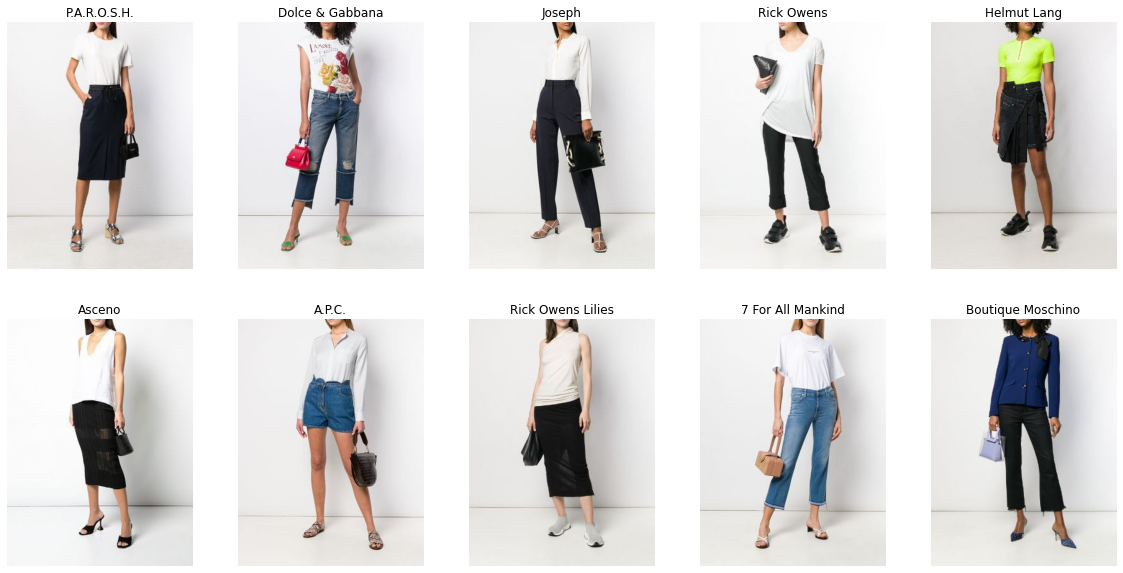



========================================== Kết quả Xception ===========================================


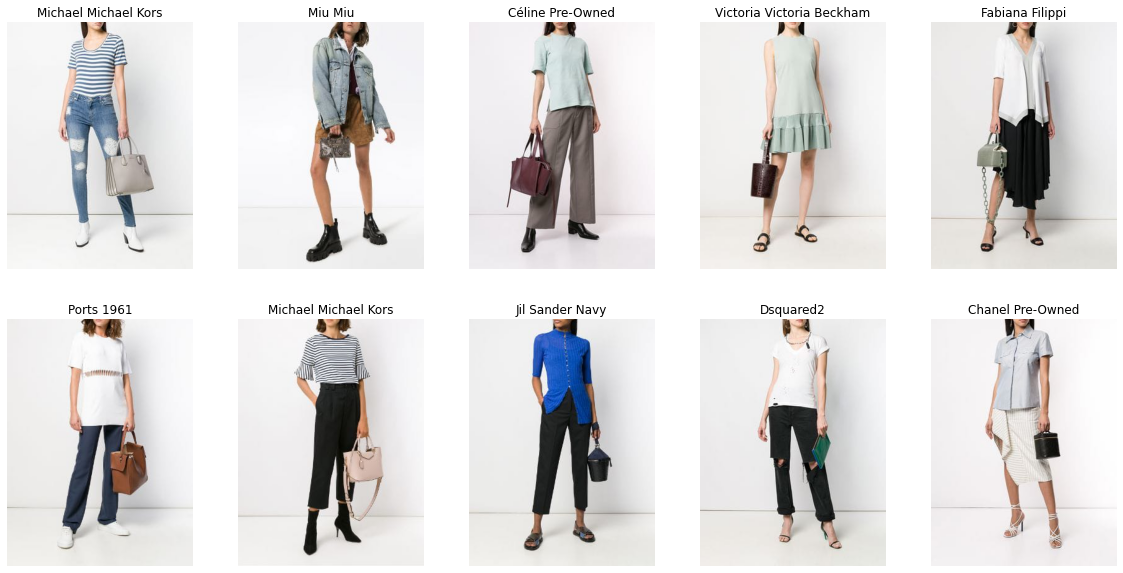

In [36]:
# Call the function
img_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS4wqVGRsgZeFnL9_gJXw2wTfdeRGFEmcKZtV2uvOqn5YYhL1XaHOcIYI1Ya4OFqhfz2kY&usqp=CAU"
testModel(img_url)

===================== HÌNH ẢNH TRUY VẤN ==========================


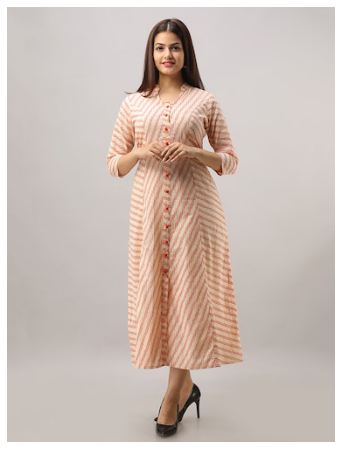

========================================== Kết quả ResNet =============================================


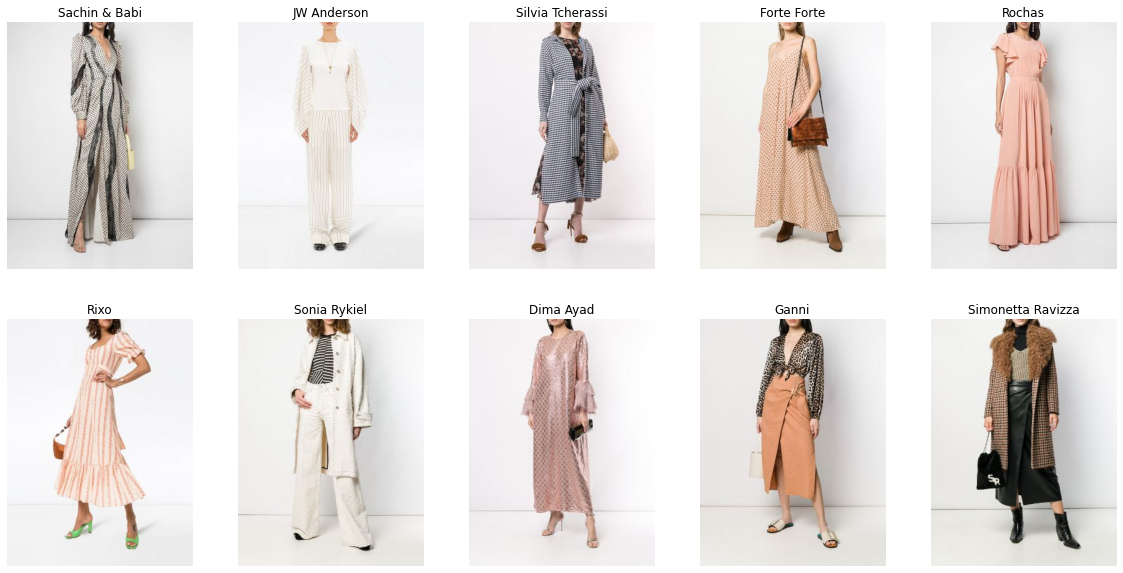



========================================== Kết quả VGG 16 ============================================


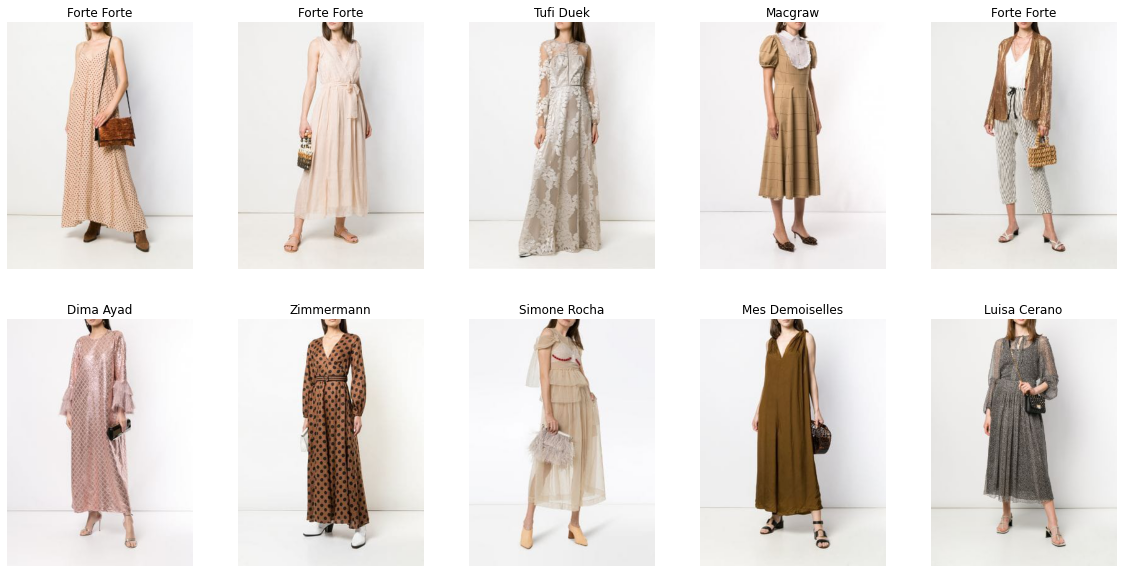



========================================== Kết quả Xception ===========================================


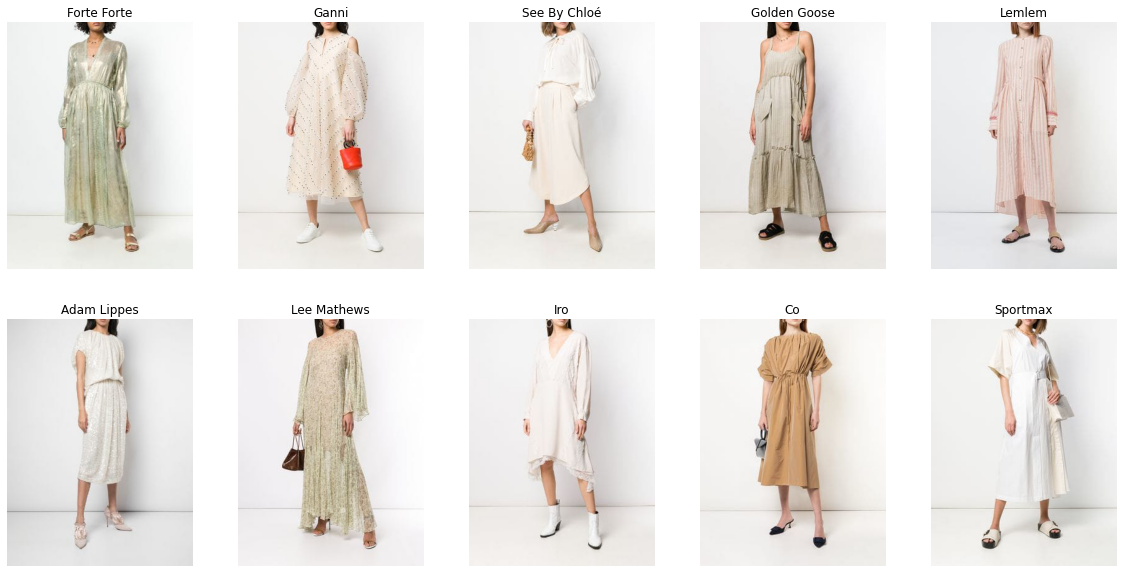

In [37]:
# Call the function
img_url = "https://img3.junaroad.com/uiproducts/16642282/pri_175_p-1598456961.jpg"
testModel(img_url)

===================== HÌNH ẢNH TRUY VẤN ==========================


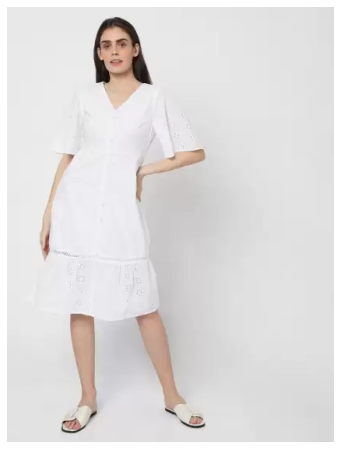

========================================== Kết quả ResNet =============================================


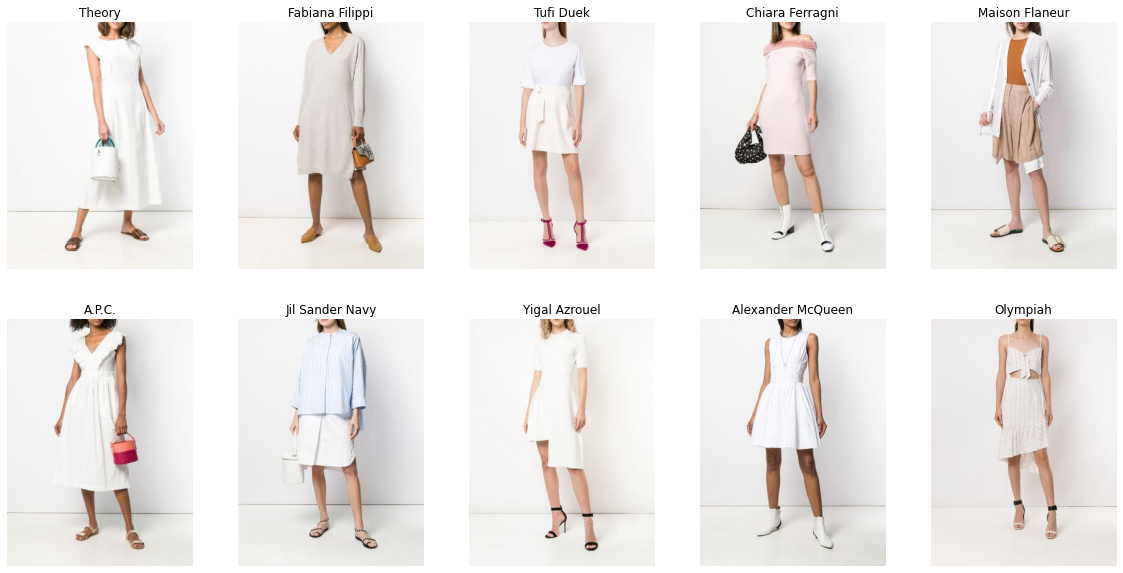



========================================== Kết quả VGG 16 ============================================


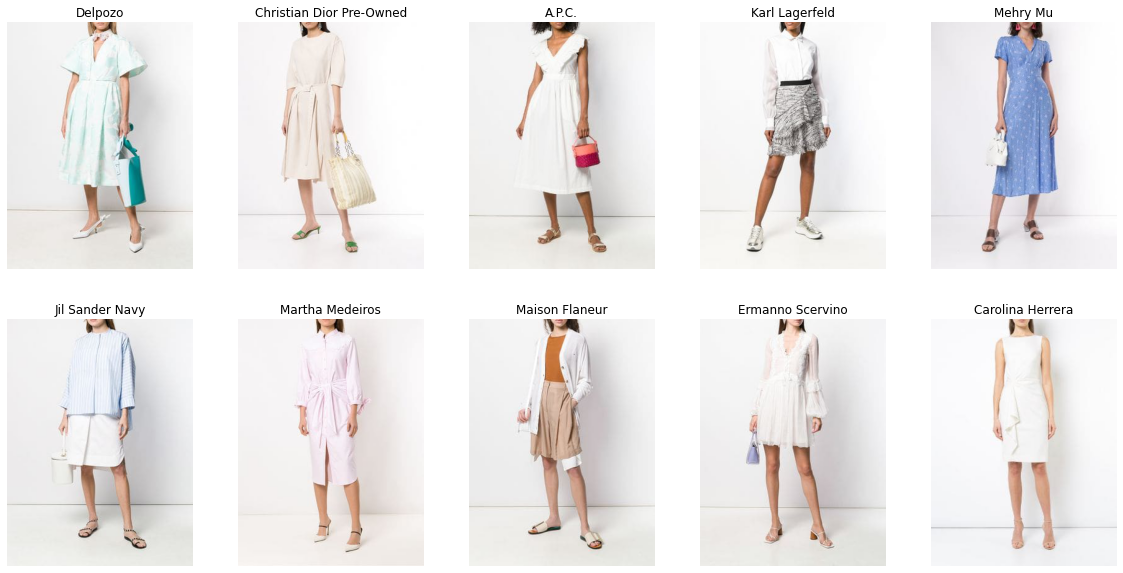



========================================== Kết quả Xception ===========================================


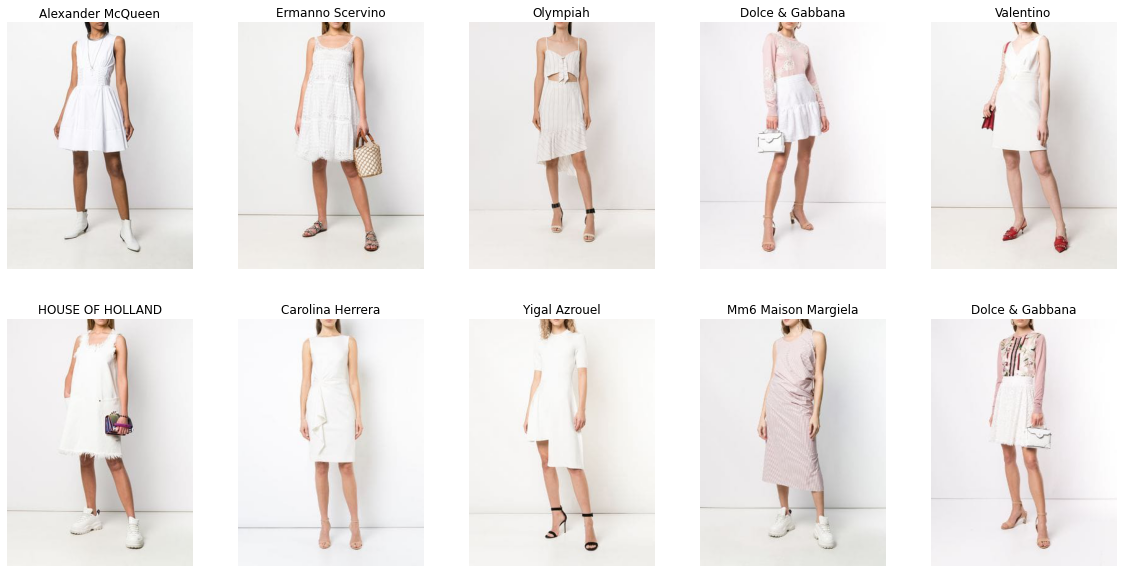

In [38]:
# Call the function
img_url = "https://assets.myntassets.com/f_webp,dpr_2.0,q_60,w_210,c_limit,fl_progressive/assets/images/16517990/2021/12/14/186c22ac-5678-401e-a491-f2f9d58b8aee1639492696377VeroModaWhiteA-LineDress1.jpg"
testModel(img_url)

===================== HÌNH ẢNH TRUY VẤN ==========================


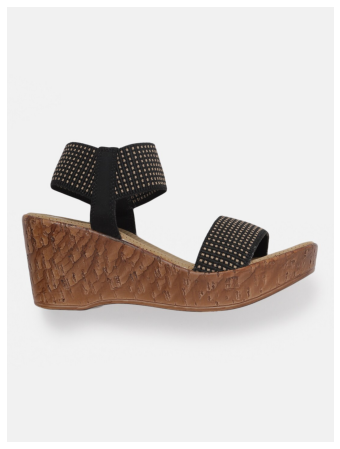

========================================== Kết quả ResNet =============================================


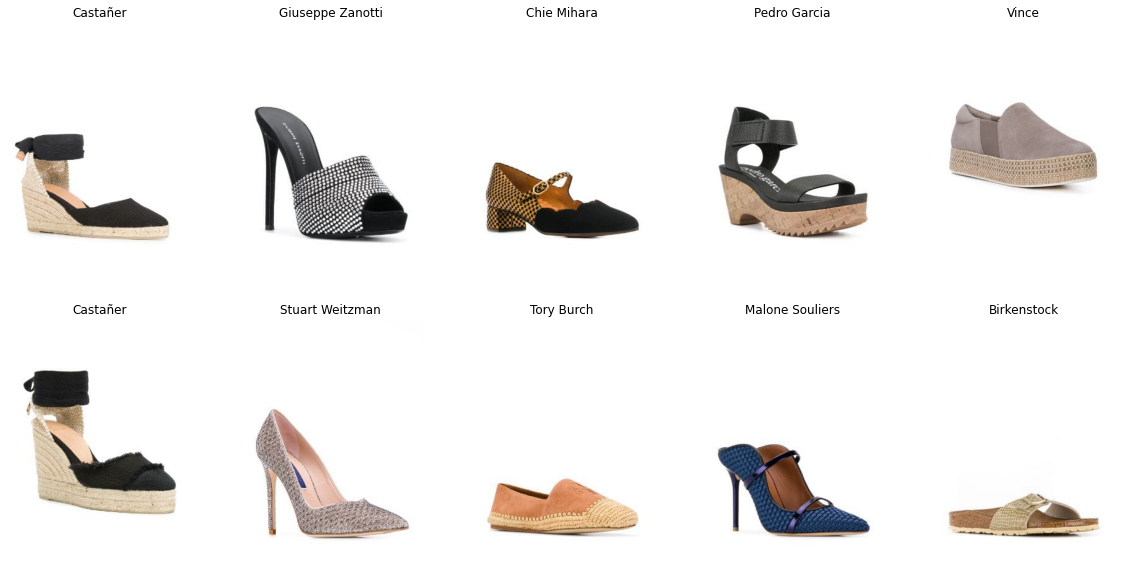



========================================== Kết quả VGG 16 ============================================


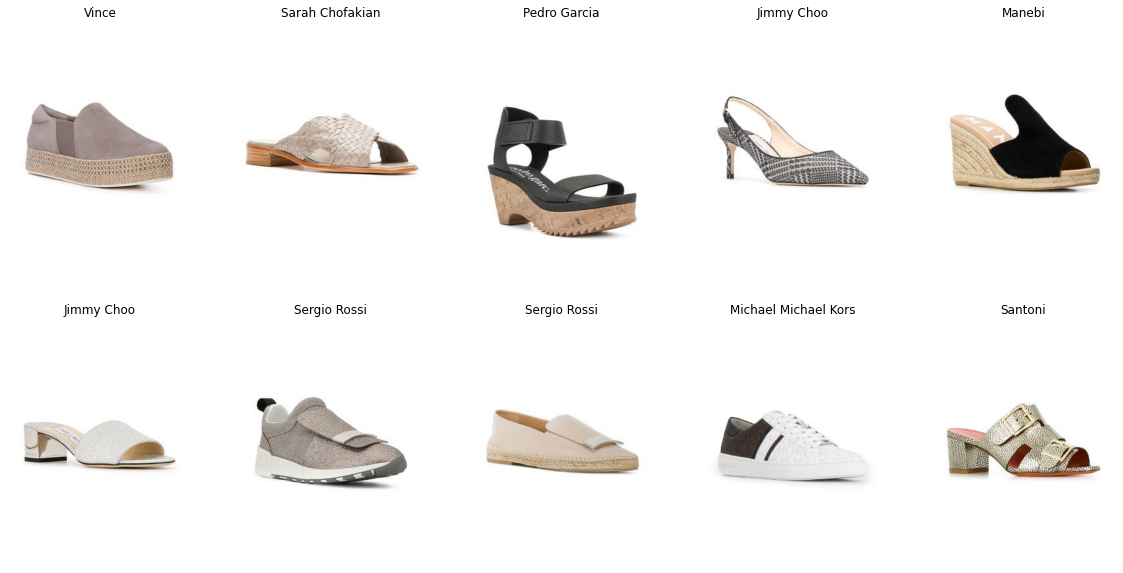



========================================== Kết quả Xception ===========================================


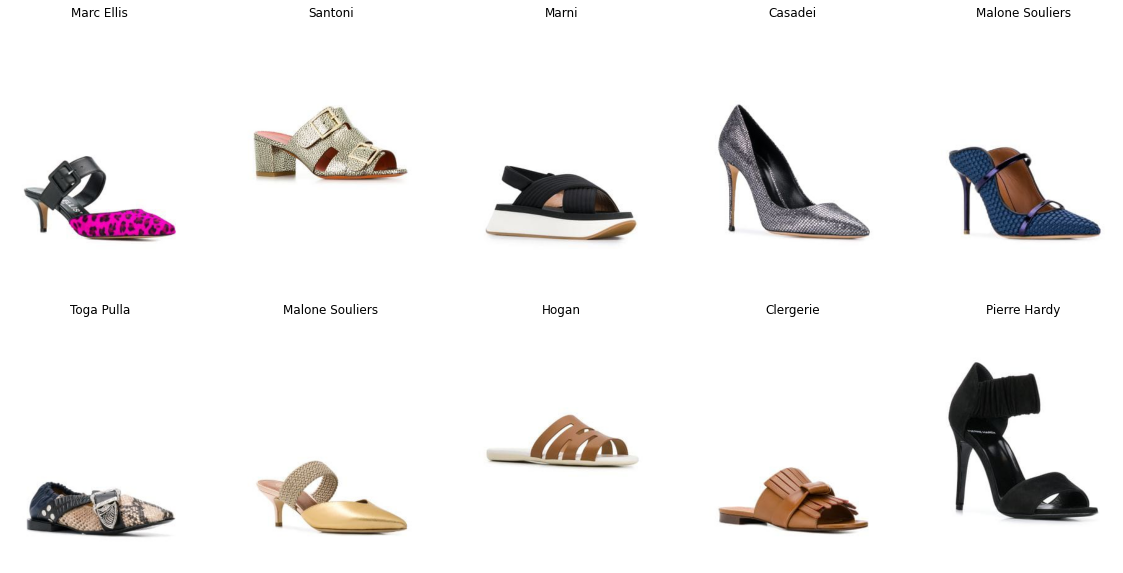

In [39]:
# Call the function
img_url = "https://assets.myntassets.com/h_1440,q_90,w_1080/v1/assets/images/8607853/2021/10/27/3dc9c459-0a09-4a64-8656-c61e762ddb2f1635331357142CatwalkWomenBlackBeigeSolidSandals2.jpg"
testModel(img_url)

===================== HÌNH ẢNH TRUY VẤN ==========================


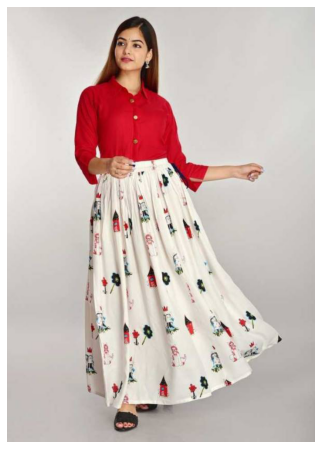

========================================== Kết quả ResNet =============================================


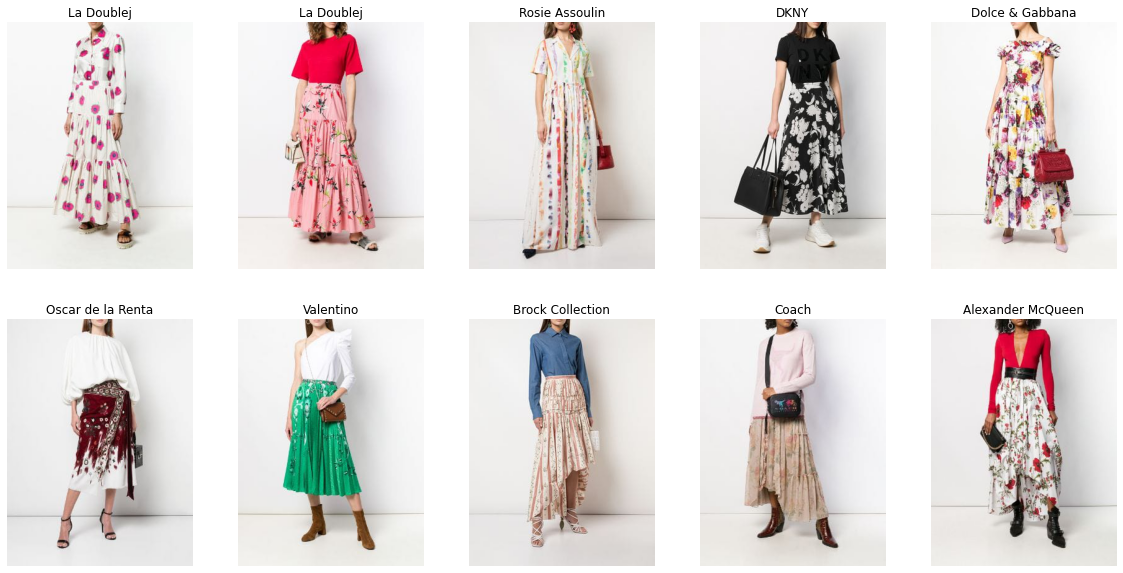



========================================== Kết quả VGG 16 ============================================


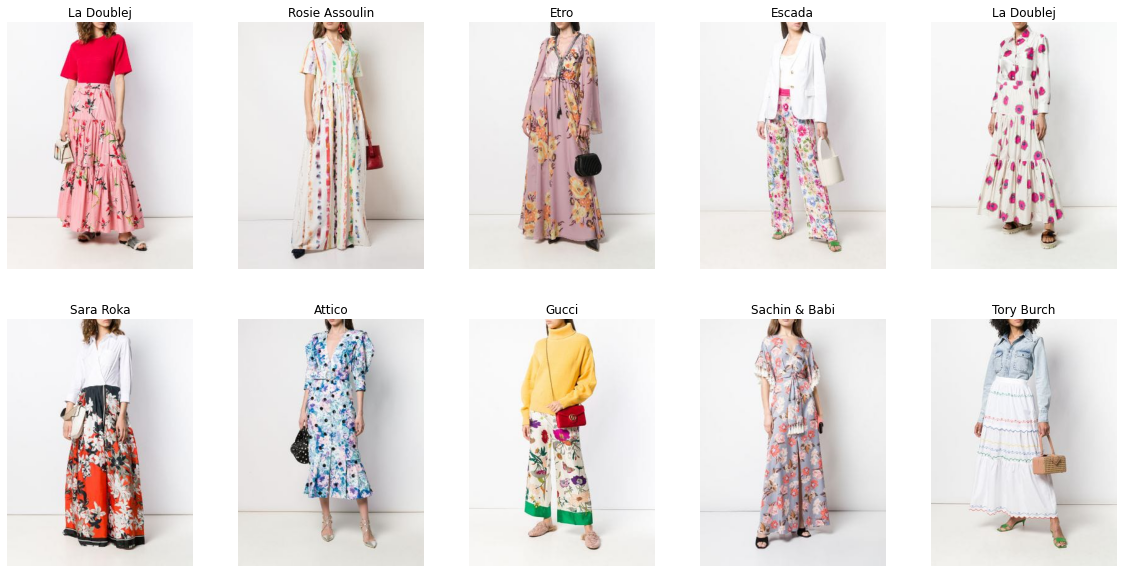



========================================== Kết quả Xception ===========================================


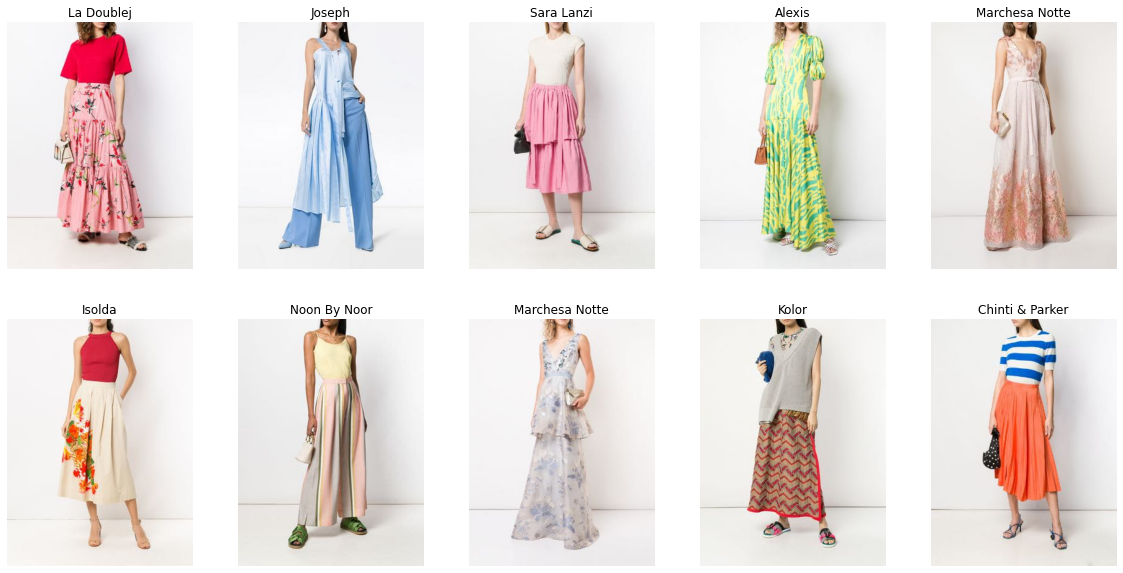

In [40]:
# Call the function
img_url = "https://rukminim2.flixcart.com/image/832/832/xif0q/ethnic-set/v/r/7/l-nfp119-shirt-and-skirt-nisha-fashion-original-imagb739wmnmdgzp-bb.jpeg?q=70&crop=false"
testModel(img_url)

===================== HÌNH ẢNH TRUY VẤN ==========================


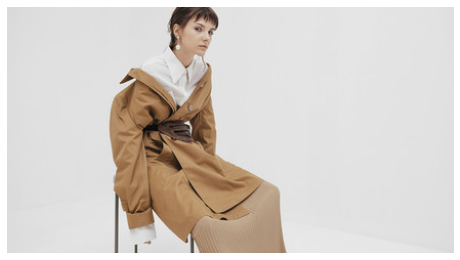

========================================== Kết quả ResNet =============================================


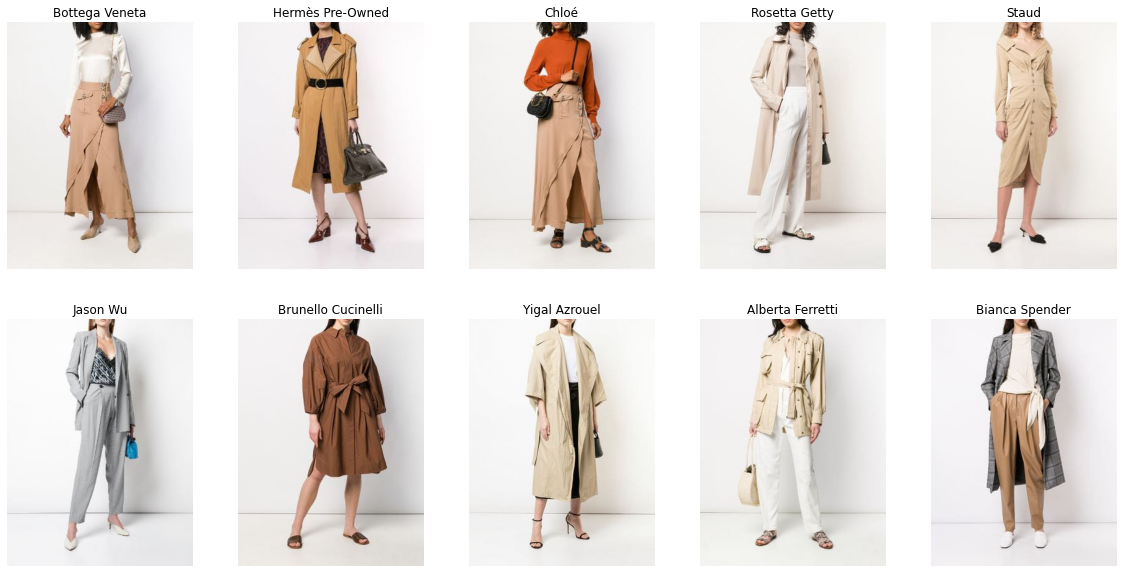



========================================== Kết quả VGG 16 ============================================


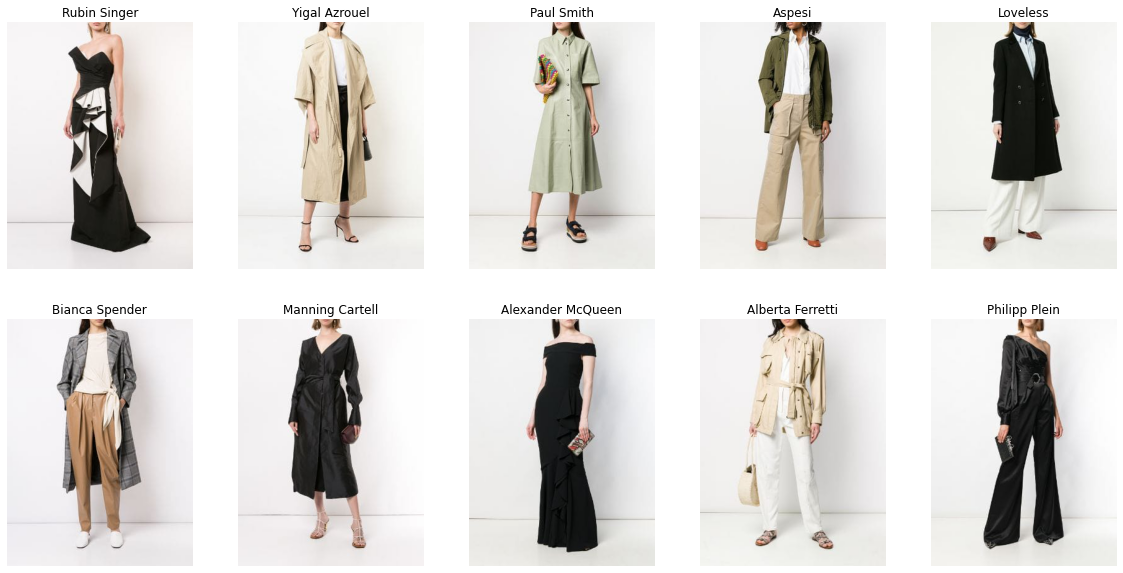



========================================== Kết quả Xception ===========================================


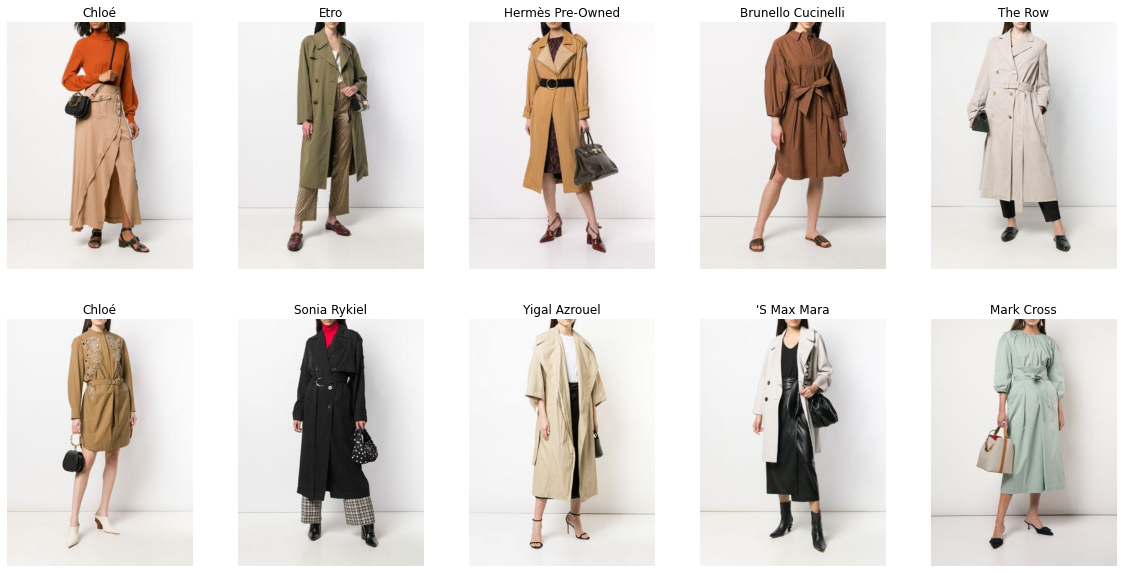

In [41]:
# Call the function
img_url = "https://t4.ftcdn.net/jpg/02/15/29/23/240_F_215292313_YylPUVeHHZ4B1XUsinDeK6DIyJYZrJGG.jpg"
testModel(img_url)

# Evaluation 

In [66]:
def average_precision_score(relevance_arr):
    """
    Tính toán Average Precision (AP) cho một mảng 10 phần tử,
    mỗi phần tử đại diện giá trị 1 (có liên quan) và 0 (không liên quan).

    :param relevance_arr: Danh sách các giá trị liên quan (1) và không liên quan (0).
    :return: Giá trị Average Precision (AP).
    """
    # Danh sách lưu trữ các giá trị precision tại mỗi vị trí có liên quan
    precision_at_k = []
    
    # Số lượng các phần tử liên quan đã gặp
    num_relevant = 0
    
    # Duyệt qua từng phần tử trong mảng
    for i, relevance in enumerate(relevance_arr):
        if relevance == 1:
            num_relevant += 1
            precision_at_k.append(num_relevant / (i + 1))
    
    # Nếu không có phần tử nào có liên quan, trả về 0
    if num_relevant == 0:
        return 0.0
    
    # Tính toán giá trị Average Precision (AP)
    average_precision = sum(precision_at_k) / num_relevant
    return average_precision

In [67]:
def AP(top_5_indexes, query_label, labels):
    """
    Tính điểm Average Precision (AP) dựa trên nhãn của hình ảnh truy vấn và các nhãn của các hình ảnh được tìm thấy.

    Parameters:
    top_5_indexes (list): Danh sách chỉ số của 5 hình ảnh tương tự nhất.
    query_label (str): Nhãn của hình ảnh truy vấn.
    labels (pd.Series): Series chứa nhãn của toàn bộ dataset.

    Returns:
    float: Điểm AP cho hình ảnh truy vấn.
    """
    # Danh sách để lưu trữ độ chính xác tại từng vị trí k
    precision_at_k = []

    # 1. Kiểm tra xem nhãn của hình ảnh tìm thấy có khớp với nhãn truy vấn hay không
    for idx in top_5_indexes:
        if labels.iloc[idx] == query_label:
            precision_at_k.append(1)
        else:
            precision_at_k.append(0)
    
    # Tính toán điểm trung bình chính xác (Average Precision Score)
    ap_score = average_precision_score(precision_at_k)
    
    return ap_score

In [68]:
index_values = np.random.randint(low = 0, high = listing_data.shape[0]-1, size = 1000)
modelImages = listing_data.iloc[index_values]['modelImages_path']

In [69]:
def evalModel():
    """
    Đánh giá hiệu suất của các mô hình (ResNet, VGG16, Xception) trên tập dữ liệu bên ngoài.
    Tính điểm trung bình AP (mAP) cho từng mô hình.
    """
    AP_resnet = []
    AP_vgg = []
    AP_xception = []
    
    labels = listing_data['product_category']
    count = 0  # Biến đếm số lần lặp

    for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
        queryImage = image.load_img(img_path)  # Tải hình ảnh truy vấn
        queryLabel = listing_data.iloc[idx]["product_category"]  # Lấy nhãn của hình ảnh truy vấn

        # Sử dụng mô hình ResNet để trích xuất đặc trưng
        queryFeatures_Resnet = resnet_feature_extractor.extract_features(queryImage)
        # Sử dụng mô hình VGG16 để trích xuất đặc trưng
        queryFeatures_Vgg = vgg_feature_extractor.extract_features(queryImage)
        # Sử dụng mô hình Xception để trích xuất đặc trưng
        queryFeatures_Xception = xception_feature_extractor.extract_features(queryImage)

        # Tính toán độ tương đồng giữa đặc trưng của hình ảnh truy vấn và các hình ảnh khác trong dataset
        # 1. ResNet
        similarity_images_resnet = {idx: np.linalg.norm(queryFeatures_Resnet - feat) for idx, feat in image_features_resnet.items()}
        similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key=lambda x: x[1])
        top_5_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted[:5]]

        # 2. VGG 16
        similarity_images_vgg = {idx: np.linalg.norm(queryFeatures_Vgg - feat) for idx, feat in image_features_vgg.items()}
        similarity_vgg_sorted = sorted(similarity_images_vgg.items(), key=lambda x: x[1])
        top_5_indexes_vgg = [idx for idx, _ in similarity_vgg_sorted[:5]]

        # 3. Xception
        similarity_images_xception = {idx: np.linalg.norm(queryFeatures_Xception - feat) for idx, feat in image_features_xception.items()}
        similarity_xception_sorted = sorted(similarity_images_xception.items(), key=lambda x: x[1])
        top_5_indexes_xception = [idx for idx, _ in similarity_xception_sorted[:5]]

        # Tính toán điểm AP cho từng mô hình
        ap_resnet = AP(top_5_indexes_resnet, queryLabel, labels)
        ap_vgg = AP(top_5_indexes_vgg, queryLabel, labels)
        ap_xception = AP(top_5_indexes_xception, queryLabel, labels)

        # Lưu điểm AP vào danh sách
        AP_resnet.append(ap_resnet)
        AP_vgg.append(ap_vgg)
        AP_xception.append(ap_xception)

        count += 1
        print(f"{count} success")

    # Tính điểm mAP cho từng mô hình
    print("MAP Score for ResNet: {}".format(np.mean(AP_resnet)))
    print("MAP Score for VGG 16: {}".format(np.mean(AP_vgg)))
    print("MAP Score for Xception: {}".format(np.mean(AP_xception)))

In [70]:
evalModel()

1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
16 success
17 success
18 success
19 success
20 success
21 success
22 success
23 success
24 success
25 success
26 success
27 success
28 success
29 success
30 success
31 success
32 success
33 success
34 success
35 success
36 success
37 success
38 success
39 success
40 success
41 success
42 success
43 success
44 success
45 success
46 success
47 success
48 success
49 success
50 success
51 success
52 success
53 success
54 success
55 success
56 success
57 success
58 success
59 success
60 success
61 success
62 success
63 success
64 success
65 success
66 success
67 success
68 success
69 success
70 success
71 success
72 success
73 success
74 success
75 success
76 success
77 success
78 success
79 success
80 success
81 success
82 success
83 success
84 success
85 success
86 success
87 success
88 success
89 success
90 success
91 success
92 succe

In [ ]:
MAP Score for ResNet: 0.6052361111111112
MAP Score for VGG 16: 0.6344027777777778
MAP Score for Xception: 0.6134305555555556